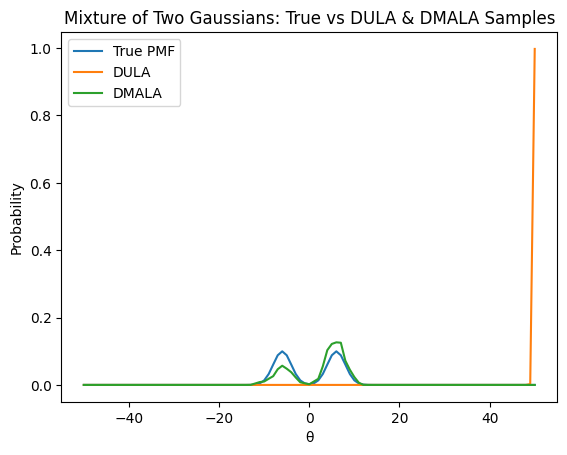

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define domain
domain = np.arange(-50, 51)
S = len(domain)

# Mixture parameters
mu1, mu2 = -6.0, 6.0
sigma = 2.0

def phi(x, mu):
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def pi_cont(x):
    return 0.5 * phi(x, mu1) + 0.5 * phi(x, mu2)

def U(x):
    return -np.log(pi_cont(x))

def grad_U(x):
    num = (x - mu1) * phi(x, mu1) + (x - mu2) * phi(x, mu2)
    den = sigma**2 * (phi(x, mu1) + phi(x, mu2))
    return num / den

def sample_dula(theta_idx, domain, grad_U, alpha):
    current = domain[theta_idx]
    g = grad_U(current)
    logits = np.array([
        0.5 * g * (domain[j] - current) - (domain[j] - current)**2 / (2 * alpha)
        for j in range(len(domain))
    ])
    probs = np.exp(logits - np.max(logits))
    probs /= probs.sum()
    return np.random.choice(len(domain), p=probs)

def sample_dmala(theta_idx, domain, U, grad_U, alpha):
    current = domain[theta_idx]
    g = grad_U(current)
    logits = np.array([
        0.5 * g * (domain[j] - current) - (domain[j] - current)**2 / (2 * alpha)
        for j in range(len(domain))
    ])
    probs = np.exp(logits - np.max(logits))
    probs /= probs.sum()
    theta_prop_idx = np.random.choice(len(domain), p=probs)
    prop = domain[theta_prop_idx]
    
    # compute acceptance ratio
    def log_q(from_val, to_val):
        d = to_val - from_val
        return 0.5 * grad_U(from_val) * d - d**2 / (2 * alpha)
    
    log_accept = -(U(prop) - U(current)) + (log_q(prop, current) - log_q(current, prop))
    if np.log(np.random.rand()) < log_accept:
        return theta_prop_idx
    else:
        return theta_idx

# Sampling parameters
alpha = 1.0
n_steps = 8000
burn_in = 1000

# Run DULA
theta = S // 2
samples_dula = []
for i in range(n_steps):
    theta = sample_dula(theta, domain, grad_U, alpha)
    if i >= burn_in:
        samples_dula.append(theta)

# Run DMALA
theta = S // 2
samples_dmala = []
for i in range(n_steps):
    theta = sample_dmala(theta, domain, U, grad_U, alpha)
    if i >= burn_in:
        samples_dmala.append(theta)

# Compute empirical PMFs
pmf_dula = np.bincount(samples_dula, minlength=S) / len(samples_dula)
pmf_dmala = np.bincount(samples_dmala, minlength=S) / len(samples_dmala)
true_pmf = pi_cont(domain)
true_pmf /= true_pmf.sum()

# Plotting
plt.figure()
plt.plot(domain, true_pmf, label='True PMF')
plt.plot(domain, pmf_dula, label='DULA')
plt.plot(domain, pmf_dmala, label='DMALA')
plt.xlabel('θ')
plt.ylabel('Probability')
plt.title('Mixture of Two Gaussians: True vs DULA & DMALA Samples')
plt.legend()
plt.show()

#


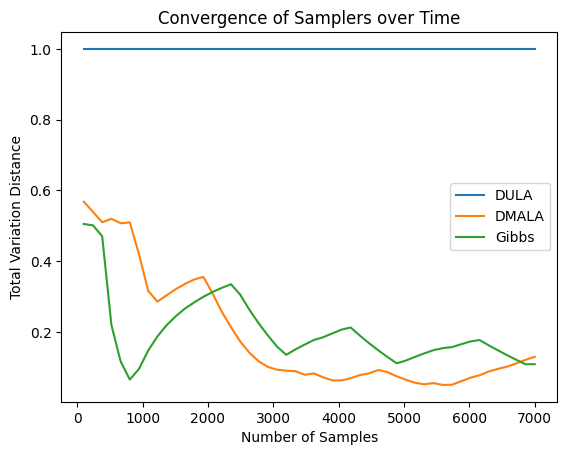

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define domain and mixture parameters
domain = np.arange(-50, 51)
S = len(domain)
mu1, mu2 = -6.0, 6.0
sigma = 2.0

# Density functions
def phi(x, mu):
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def pi_cont(x):
    return 0.5 * phi(x, mu1) + 0.5 * phi(x, mu2)

true_pmf = pi_cont(domain)
true_pmf /= true_pmf.sum()

def U(x):
    return -np.log(pi_cont(x))

def grad_U(x):
    num = (x - mu1) * phi(x, mu1) + (x - mu2) * phi(x, mu2)
    den = sigma**2 * (phi(x, mu1) + phi(x, mu2))
    return num / den

# Sampler definitions
def sample_dula(theta_idx, domain, grad_U, alpha):
    current = domain[theta_idx]
    g = grad_U(current)
    logits = np.array([
        0.5 * g * (domain[j] - current) - (domain[j] - current)**2 / (2 * alpha)
        for j in range(len(domain))
    ])
    probs = np.exp(logits - np.max(logits))
    probs /= probs.sum()
    return np.random.choice(len(domain), p=probs)

def sample_dmala(theta_idx, domain, U, grad_U, alpha):
    current = domain[theta_idx]
    g = grad_U(current)
    logits = np.array([
        0.5 * g * (domain[j] - current) - (domain[j] - current)**2 / (2 * alpha)
        for j in range(len(domain))
    ])
    probs = np.exp(logits - np.max(logits))
    probs /= probs.sum()
    theta_prop_idx = np.random.choice(len(domain), p=probs)
    prop = domain[theta_prop_idx]
    
    def log_q(from_val, to_val):
        d = to_val - from_val
        return 0.5 * grad_U(from_val) * d - d**2 / (2 * alpha)
    
    log_accept = -(U(prop) - U(current)) + (log_q(prop, current) - log_q(current, prop))
    if np.log(np.random.rand()) < log_accept:
        return theta_prop_idx
    else:
        return theta_idx

def sample_gibbs(theta_idx, domain):
    x = domain[theta_idx]
    # sample mixture component z | x
    p_z1 = phi(x, mu1) / (phi(x, mu1) + phi(x, mu2))
    z = np.random.choice([1, 2], p=[p_z1, 1 - p_z1])
    # sample x | z
    probs = phi(domain, mu1 if z == 1 else mu2)
    probs /= probs.sum()
    return np.random.choice(len(domain), p=probs)

# Run samplers
alpha = 1.0
n_steps = 8000
burn_in = 1000

def run_sampler(sample_fn):
    theta = S // 2
    samples = []
    for i in range(n_steps):
        theta = sample_fn(theta)
        if i >= burn_in:
            samples.append(theta)
    return np.array(samples)

samples_dula = run_sampler(lambda idx: sample_dula(idx, domain, grad_U, alpha))
samples_dmala = run_sampler(lambda idx: sample_dmala(idx, domain, U, grad_U, alpha))
samples_gibbs = run_sampler(lambda idx: sample_gibbs(idx, domain))

# Compute Total Variation distance over time
def tv_distance(emp_pmf, true_pmf):
    return 0.5 * np.abs(emp_pmf - true_pmf).sum()

intervals = np.linspace(100, len(samples_dula), 50, dtype=int)
dist_dula, dist_dmala, dist_gibbs = [], [], []

for k in intervals:
    pmf_d = np.bincount(samples_dula[:k], minlength=S) / k
    pmf_m = np.bincount(samples_dmala[:k], minlength=S) / k
    pmf_g = np.bincount(samples_gibbs[:k], minlength=S) / k
    dist_dula.append(tv_distance(pmf_d, true_pmf))
    dist_dmala.append(tv_distance(pmf_m, true_pmf))
    dist_gibbs.append(tv_distance(pmf_g, true_pmf))

# Plot convergence
plt.figure()
plt.plot(intervals, dist_dula, label='DULA')
plt.plot(intervals, dist_dmala, label='DMALA')
plt.plot(intervals, dist_gibbs, label='Gibbs')
plt.xlabel('Number of Samples')
plt.ylabel('Total Variation Distance')
plt.title('Convergence of Samplers over Time')
plt.legend()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

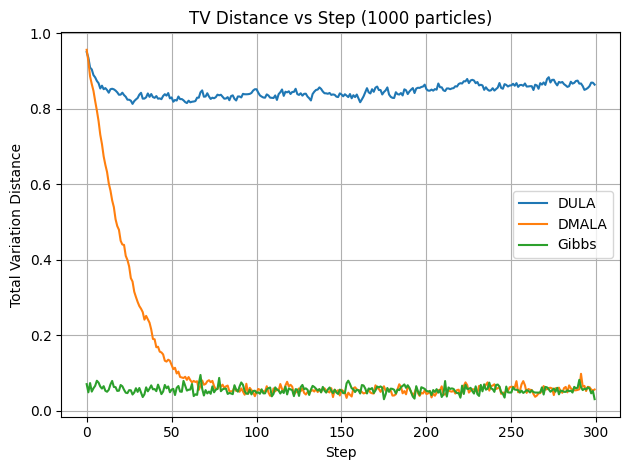

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define domain and mixture parameters
domain = np.arange(-50, 51)
S = len(domain)
mu1, mu2 = -6.0, 6.0
sigma = 2.0

def phi(x, mu):
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def pi_cont(x):
    return 0.5 * phi(x, mu1) + 0.5 * phi(x, mu2)

true_pmf = pi_cont(domain)
true_pmf /= true_pmf.sum()

def U(x):
    return -np.log(pi_cont(x))

def grad_U(x):
    num = (x - mu1) * phi(x, mu1) + (x - mu2) * phi(x, mu2)
    den = sigma**2 * (phi(x, mu1) + phi(x, mu2))
    return num / den

# Particle samplers (all work with a batch of particle indices)
def sample_dula_batch(particle_idxs, domain, grad_U, alpha):
    updated = []
    for idx in particle_idxs:
        current = domain[idx]
        g = grad_U(current)
        logits = 0.5 * g * (domain - current) - (domain - current)**2 / (2 * alpha)
        probs = np.exp(logits - np.max(logits))
        probs /= probs.sum()
        updated.append(np.random.choice(len(domain), p=probs))
    return np.array(updated)

def sample_dmala_batch(particle_idxs, domain, U, grad_U, alpha):
    updated = []
    for idx in particle_idxs:
        current = domain[idx]
        g = grad_U(current)
        logits = 0.5 * g * (domain - current) - (domain - current)**2 / (2 * alpha)
        probs = np.exp(logits - np.max(logits))
        probs /= probs.sum()
        prop_idx = np.random.choice(len(domain), p=probs)
        prop = domain[prop_idx]

        def log_q(from_val, to_val):
            d = to_val - from_val
            return 0.5 * grad_U(from_val) * d - d**2 / (2 * alpha)

        log_accept = -(U(prop) - U(current)) + (log_q(prop, current) - log_q(current, prop))
        if np.log(np.random.rand()) < log_accept:
            updated.append(prop_idx)
        else:
            updated.append(idx)
    return np.array(updated)

def sample_gibbs_batch(particle_idxs, domain):
    updated = []
    for idx in particle_idxs:
        x = domain[idx]
        p_z1 = phi(x, mu1) / (phi(x, mu1) + phi(x, mu2))
        z = np.random.choice([1, 2], p=[p_z1, 1 - p_z1])
        probs = phi(domain, mu1 if z == 1 else mu2)
        probs /= probs.sum()
        updated.append(np.random.choice(len(domain), p=probs))
    return np.array(updated)

# Run sampler with particle tracking
alpha = 1.0
n_steps = 300  # Use fewer steps for performance
n_particles = 1000

def run_sampler_particles(sample_fn):
    particle_idxs = np.full(n_particles, S // 2)  # Start from center
    pmf_list = []
    for _ in range(n_steps):
        particle_idxs = sample_fn(particle_idxs)
        pmf = np.bincount(particle_idxs, minlength=S) / n_particles
        pmf_list.append(pmf)
    return pmf_list

pmfs_dula = run_sampler_particles(lambda idxs: sample_dula_batch(idxs, domain, grad_U, alpha))
pmfs_dmala = run_sampler_particles(lambda idxs: sample_dmala_batch(idxs, domain, U, grad_U, alpha))
pmfs_gibbs = run_sampler_particles(lambda idxs: sample_gibbs_batch(idxs, domain))

# Compute TV distance at each step
def tv_distance(p, q):
    return 0.5 * np.abs(p - q).sum()

tv_dula = [tv_distance(p, true_pmf) for p in pmfs_dula]
tv_dmala = [tv_distance(p, true_pmf) for p in pmfs_dmala]
tv_gibbs = [tv_distance(p, true_pmf) for p in pmfs_gibbs]

# Plot convergence
plt.figure()
plt.plot(tv_dula, label='DULA')
plt.plot(tv_dmala, label='DMALA')
plt.plot(tv_gibbs, label='Gibbs')
plt.xlabel('Step')
plt.ylabel('TV Distance to the true π')
plt.title(r'Convergence on Mixture of Gaussians')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

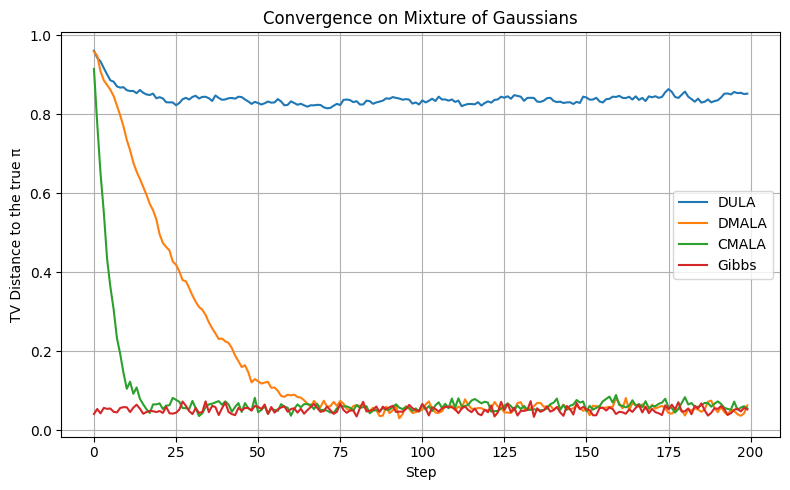

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define domain and mixture parameters
domain = np.arange(-50, 51)
S = len(domain)
mu1, mu2 = -6.0, 6.0
sigma = 2.0

def phi(x, mu):
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def pi_cont(x):
    return 0.5 * phi(x, mu1) + 0.5 * phi(x, mu2)

true_pmf = pi_cont(domain)
true_pmf /= true_pmf.sum()

def U(x):
    return -np.log(pi_cont(x))

def grad_U(x):
    num = (x - mu1) * phi(x, mu1) + (x - mu2) * phi(x, mu2)
    den = sigma**2 * (phi(x, mu1) + phi(x, mu2))
    return num / den

# Discrete samplers as before...
# sample_dula_batch, sample_dmala_batch, sample_gibbs_batch (unchanged)

# Particle samplers (all work with a batch of particle indices)
def sample_dula_batch(particle_idxs, domain, grad_U, alpha):
    updated = []
    for idx in particle_idxs:
        current = domain[idx]
        g = grad_U(current)
        logits = 0.5 * g * (domain - current) - (domain - current)**2 / (2 * alpha)
        probs = np.exp(logits - np.max(logits))
        probs /= probs.sum()
        updated.append(np.random.choice(len(domain), p=probs))
    return np.array(updated)

def sample_dmala_batch(particle_idxs, domain, U, grad_U, alpha):
    updated = []
    for idx in particle_idxs:
        current = domain[idx]
        g = grad_U(current)
        logits = 0.5 * g * (domain - current) - (domain - current)**2 / (2 * alpha)
        probs = np.exp(logits - np.max(logits))
        probs /= probs.sum()
        prop_idx = np.random.choice(len(domain), p=probs)
        prop = domain[prop_idx]

        def log_q(from_val, to_val):
            d = to_val - from_val
            return 0.5 * grad_U(from_val) * d - d**2 / (2 * alpha)

        log_accept = -(U(prop) - U(current)) + (log_q(prop, current) - log_q(current, prop))
        if np.log(np.random.rand()) < log_accept:
            updated.append(prop_idx)
        else:
            updated.append(idx)
    return np.array(updated)

def sample_gibbs_batch(particle_idxs, domain):
    updated = []
    for idx in particle_idxs:
        x = domain[idx]
        p_z1 = phi(x, mu1) / (phi(x, mu1) + phi(x, mu2))
        z = np.random.choice([1, 2], p=[p_z1, 1 - p_z1])
        probs = phi(domain, mu1 if z == 1 else mu2)
        probs /= probs.sum()
        updated.append(np.random.choice(len(domain), p=probs))
    return np.array(updated)
# --- New: Continuous MALA (cMALA) ---
def sample_cmala_batch(particle_idxs, domain, U, grad_U, alpha):
    """
    For each discrete-indexed particle, perform a continuous MALA update:
      y = x - alpha * grad_U(x) + sqrt(2*alpha) * normal_noise
    then accept/reject with MH acceptance, and project back to nearest grid index.
    """
    updated = []
    for idx in particle_idxs:
        x = domain[idx]
        # propose in continuous space
        noise = np.random.randn()
        y = x - alpha * grad_U(x) + np.sqrt(2 * alpha) * noise

        # compute log-target and reverse proposal density
        def log_q(to_val, from_val):
            # Gaussian: mean = from_val - alpha*grad_U(from_val)
            m = from_val - alpha * grad_U(from_val)
            return - (to_val - m)**2 / (4 * alpha)

        # MH acceptance
        log_accept = -U(y) + U(x) + log_q(x, y) - log_q(y, x)
        if np.log(np.random.rand()) < log_accept:
            x_new = y
        else:
            x_new = x

        # map back to nearest grid point
        idx_new = np.argmin(np.abs(domain - x_new))
        updated.append(idx_new)
    return np.array(updated)

# Run sampler with particle tracking
alpha = 0.75
n_steps = 200
n_particles = 1000

def run_sampler_particles(sample_fn):
    particle_idxs = np.full(n_particles, S // 2)  # Start from center
    pmf_list = []
    for _ in range(n_steps):
        particle_idxs = sample_fn(particle_idxs)
        pmf = np.bincount(particle_idxs, minlength=S) / n_particles
        pmf_list.append(pmf)
    return pmf_list

pmfs_dula  = run_sampler_particles(lambda idxs: sample_dula_batch(idxs, domain, grad_U, alpha))
pmfs_dmala = run_sampler_particles(lambda idxs: sample_dmala_batch(idxs, domain, U, grad_U, alpha))
pmfs_gibbs = run_sampler_particles(lambda idxs: sample_gibbs_batch(idxs, domain))
pmfs_cmala = run_sampler_particles(lambda idxs: sample_cmala_batch(idxs, domain, U, grad_U, alpha))

# Compute TV distance at each step
def tv_distance(p, q):
    return 0.5 * np.abs(p - q).sum()

tv_dula  = [tv_distance(p, true_pmf) for p in pmfs_dula]
tv_dmala = [tv_distance(p, true_pmf) for p in pmfs_dmala]
tv_gibbs = [tv_distance(p, true_pmf) for p in pmfs_gibbs]
tv_cmala = [tv_distance(p, true_pmf) for p in pmfs_cmala]

# Plot convergence
plt.figure(figsize=(8,5))
plt.plot(tv_dula,  label='DULA')
plt.plot(tv_dmala, label='DMALA')
plt.plot(tv_cmala, label='CMALA')   
plt.plot(tv_gibbs, label='Gibbs')
plt.xlabel('Step')
plt.ylabel('TV Distance to the true π')
plt.title(r'Convergence on Mixture of Gaussians')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

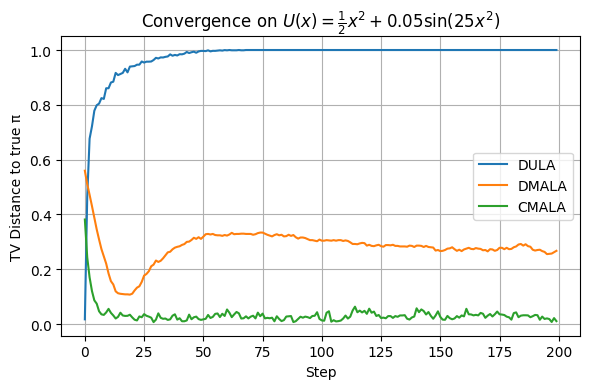

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ── Domain and target definition ─────────────────────────────────────────────────
domain = np.arange(-50, 51)
S = len(domain)
delta = 0.05
omega = 25.0

def U(x):
    return 0.5 * x**2 + delta * np.sin(omega * x**2)

def grad_U(x):
    return x + 2 * delta * omega * x * np.cos(omega * x**2)

# ── True pmf ────────────────────────────────────────────────────────────────────
true_pmf = np.exp(-U(domain))
true_pmf /= true_pmf.sum()

# ── DULA and DMALA samplers ─────────────────────────────────────────────────────
def sample_dula_batch(particle_idxs, domain, grad_U, alpha):
    updated = []
    for idx in particle_idxs:
        current = domain[idx]
        g = grad_U(current)
        logits = 0.5 * g * (domain - current) - (domain - current)**2 / (2 * alpha)
        probs = np.exp(logits - logits.max())
        probs /= probs.sum()
        updated.append(np.random.choice(len(domain), p=probs))
    return np.array(updated)

def sample_dmala_batch(particle_idxs, domain, U, grad_U, alpha):
    updated = []
    for idx in particle_idxs:
        current = domain[idx]
        g = grad_U(current)
        logits = 0.5 * g * (domain - current) - (domain - current)**2 / (2 * alpha)
        probs = np.exp(logits - logits.max())
        probs /= probs.sum()
        prop_idx = np.random.choice(len(domain), p=probs)
        prop = domain[prop_idx]

        def log_q(from_val, to_val):
            d = to_val - from_val
            return 0.5 * grad_U(from_val) * d - d**2 / (2 * alpha)

        log_accept = -(U(prop) - U(current)) + (log_q(prop, current) - log_q(current, prop))
        if np.log(np.random.rand()) < log_accept:
            updated.append(prop_idx)
        else:
            updated.append(idx)
    return np.array(updated)

# ── Runner for DULA/DMALA ────────────────────────────────────────────────────────
alpha = 1.0
n_steps = 200
n_particles = 1000

def run_discrete_sampler(sample_fn):
    particle_idxs = np.full(n_particles, S // 2)
    pmf_list = []
    for _ in range(n_steps):
        if sample_fn is sample_dmala_batch:
            particle_idxs = sample_fn(particle_idxs, domain, U, grad_U, alpha)
        else:
            particle_idxs = sample_fn(particle_idxs, domain, grad_U, alpha)
        pmf = np.bincount(particle_idxs, minlength=S) / n_particles
        pmf_list.append(pmf)
    return pmf_list

pmfs_dula = run_discrete_sampler(sample_dula_batch)
pmfs_dmala = run_discrete_sampler(sample_dmala_batch)

# ── Continuous MALA sampler ─────────────────────────────────────────────────────
h = alpha
current = np.zeros(n_particles)
pmf_list_cont = []

for _ in range(n_steps):
    noise = np.random.randn(n_particles)
    prop = current - h * grad_U(current) + np.sqrt(2 * h) * noise

    log_q_curr_to_prop = - (prop - current + h * grad_U(current))**2 / (4 * h)
    log_q_prop_to_curr = - (current - prop + h * grad_U(prop))**2 / (4 * h)
    
    log_accept = (-U(prop) + U(current)) + (log_q_prop_to_curr - log_q_curr_to_prop)
    accept = np.log(np.random.rand(n_particles)) < log_accept
    current[accept] = prop[accept]

    idxs = np.rint(current).astype(int)
    idxs = np.clip(idxs, domain[0], domain[-1]) - domain[0]
    pmf = np.bincount(idxs, minlength=S) / n_particles
    pmf_list_cont.append(pmf)

# ── TV distance ─────────────────────────────────────────────────────────────────
def tv_distance(p, q):
    return 0.5 * np.abs(p - q).sum()

tv_dula = [tv_distance(p, true_pmf) for p in pmfs_dula]
tv_dmala = [tv_distance(p, true_pmf) for p in pmfs_dmala]
tv_cont = [tv_distance(p, true_pmf) for p in pmf_list_cont]

# ── Plot convergence ────────────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(tv_dula,  label='DULA')
plt.plot(tv_dmala, label='DMALA')
plt.plot(tv_cont,  label='CMALA')
plt.xlabel('Step')
plt.ylabel('TV Distance to true π')
plt.title('Convergence on $U(x)=\frac{1}{2}x^2 + 0.05\sin(25x^2)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
